In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner
import pickle
import os 

if os.path.isdir('/mnt/ceph/users/mgabrie/'):
    ceph_home = '/mnt/ceph/users/mgabrie/nfsampler/'
elif os.path.isdir('/Users/marylou/Dropbox/Postdoc/Experiments/ceph/nfsampler/'):
    ceph_home = '/Users/marylou/Dropbox/Postdoc/Experiments/ceph/nfsampler/'
else:
    raise RuntimeError('Data path not understood')

from plot import draw_corner, draw_kepler_results
from utils import rv_model, log_likelihood, log_prior, sample_prior, get_kepler_params_and_log_jac


In [2]:
random_id = '6256' # long with few observations - NF not well trained
random_id = '688' # n=25 obs - samples all over the places
random_id = '3028' # n=50 obs - samples concentrated
random_id = '6377' # simple test
random_id = '7489' #after merging Packaging branch
# random_id = '5262' # only local
random_id = '6385' #long run - I think we are seeing mode collapse
random_id = '3164' #testing training on local samples

with open(ceph_home + 'results_{:s}.pkl'.format(random_id), 'rb') as f:
    results = pickle.load(f)

for key,val in results.items():
        exec(key + '=val')

labels = ['v0', 'log_s2', 'log_period', 'log_k', 'sin_phi_',
                            'cos_phi_', 'ecc_', 'sin_w_', 'cos_w_']

n_chains = chains.shape[0]
local_steps = local_accs.shape[1]
global_steps = global_accs.shape[1] if len(global_accs > 1) else 0

print('Id {:s} - {:d} chains - {:d} local steps - {:d} global steps'.format(random_id, n_chains, local_steps, global_steps), end='')

if len(loss_vals.shape) > 1:
    n_loop = loss_vals.shape[0]
    n_epoch = loss_vals.shape[1]
    print('loops {:d} - epochs {:d}'.format(n_loop, n_epoch))
else:
    n_loop, n_epoch = 0, 0 
    print('')


Id 3164 - 50 chains - 500 local steps - 1 global stepsloops 1 - epochs 500


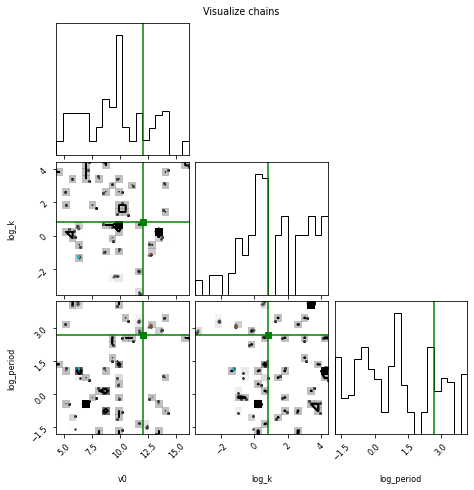

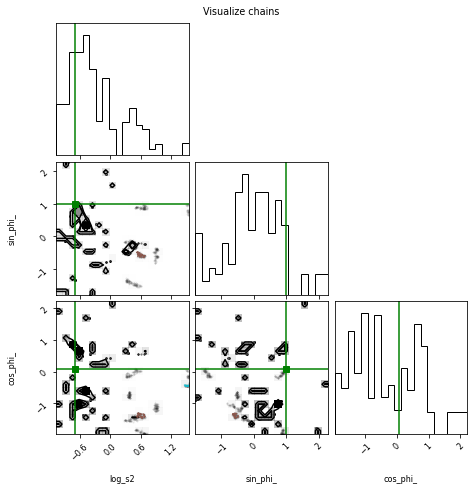

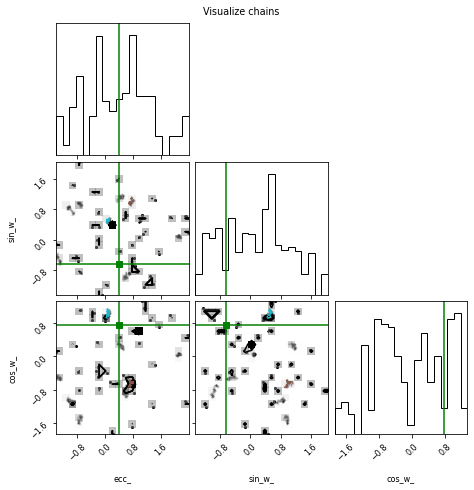

In [3]:
# fig_corner = draw_corner(chains, true_params, labels, labelpad=0.3)

for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:

    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=10, n_last_spls=100)
   

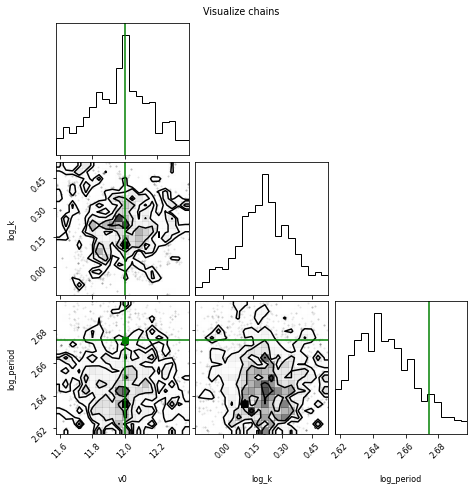

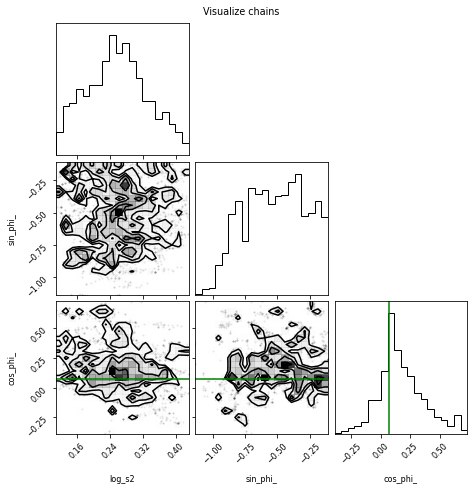

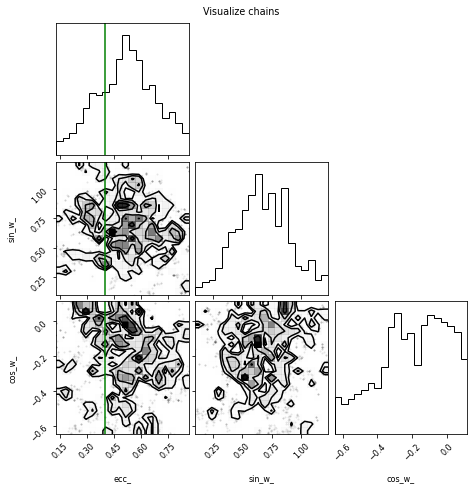

In [7]:
for indices in [[0, 3, 2], [1, 4, 5], [6, 7, 8]]:
    n_dim = chains.shape[-1]
    fig_corner = draw_corner(chains[..., indices], true_params[indices], [labels[l] for l in indices], labelpad=0., n_plot_chains=0, n_last_spls=100)
    axes = np.array(fig_corner.axes).reshape((len(indices), len(indices)))
    for yy,yi in enumerate(indices):
        for xx,xi in enumerate(indices[:yy]):
            ax = axes[yy, xx]
            ax.plot(nf_samples[1][:, xi], nf_samples[1][:, yi], 'o', alpha=0.95)
    

Superpose chains + samples from the Flow

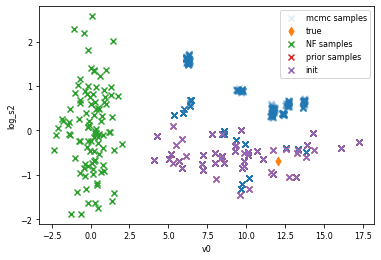

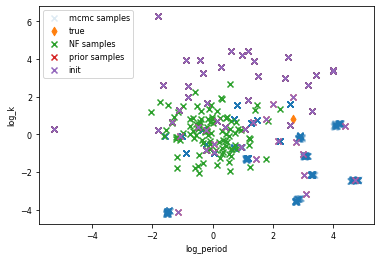

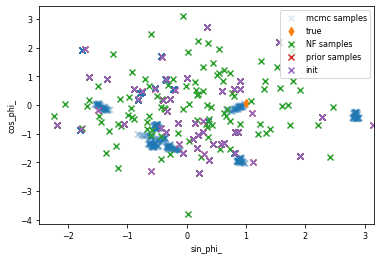

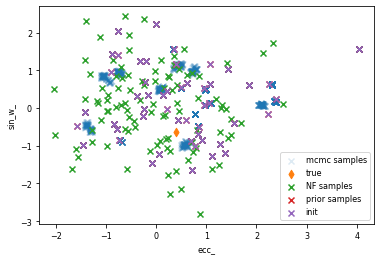

In [4]:
n_dim = chains.shape[-1]
indices = [0, 1]
for indices in [[0,1], [2,3], [4,5], [6,7]]:

    plt.figure()
    ax = plt.subplot(111)

    n_last_spls = 100
    samples = chains[:, -n_last_spls:, :].reshape(-1, n_dim)
    plt.scatter(samples[:, indices[0]], samples[:, indices[1]], alpha=0.15, label='mcmc samples', marker='x')
    plt.scatter(true_params[indices[0]], true_params[indices[1]], label='true', marker='d')
    plt.scatter(nf_samples[1][:, indices[0]], nf_samples[1][:, indices[1]], label='NF samples', marker='x')
    plt.scatter(prior_samples[:, indices[0]], prior_samples[:, indices[1]], alpha=1, label='prior samples', marker='x')
    ax.autoscale(False)
    plt.scatter(optimized_init[:, indices[0]], optimized_init[:, indices[1]], alpha=1, label='init', marker='x')
    
    plt.legend()
    plt.xlabel(labels[indices[0]])
    plt.ylabel(labels[indices[1]])



In [10]:
loss_vals.shape

(20, 10)

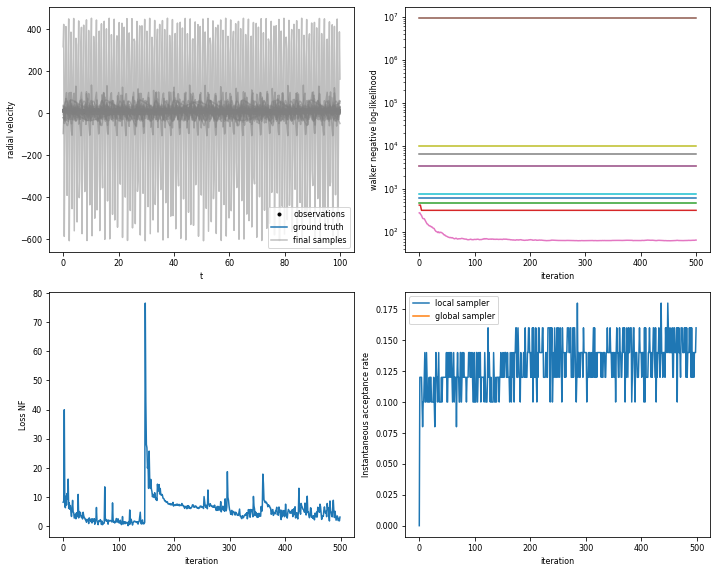

In [5]:

def log_posterior(x):
    return  log_likelihood(x.T, t, rv_err, rv_obs) + log_prior(x,**prior_kwargs)

# loss_vals = loss_vals.reshape(5, 20).T.reshape(-1)
loss_vals = loss_vals.reshape(-1)

fig_results = draw_kepler_results(chains, true_params, t, rv_obs, loss_vals,
                                  local_accs, global_accs, rv_model, log_posterior, get_kepler_params_and_log_jac)

Computing Rhat values

In [24]:
import arviz as az

dims = {ll : l for l,ll in enumerate(labels)}
n_last_spls = 1000
chains_data = az.convert_to_dataset(chains[:, -n_last_spls:, :], dims=dims)
chains_data
az.rhat(chains_data).values()

ValuesView(<xarray.Dataset>
Dimensions:  (x_dim_0: 9)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 8
Data variables:
    x        (x_dim_0) float64 1.177 1.257 1.469 1.12 ... 1.234 1.162 1.297)

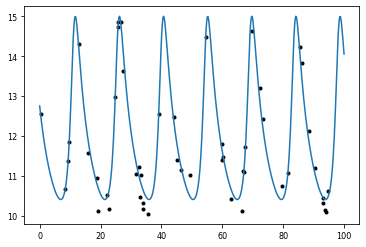

In [26]:
plt.plot(t, rv_obs, ".k", label='observations')
x = np.linspace(0, 100, 500)
plt.plot(x, rv_model(true_params, x), "C0", label='ground truth')